In [1]:
%pip install numpy matplotlib seaborn scipy statsmodels

In [2]:
# Importing packages that I will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load the clean data
df = pd.read_csv('clean_data.csv')

# Calculate the 2-point and XP success rates for each team
df['2PPerc'] = df['2PM'] / df['2PA'] * 100
df['XPPerc'] = df['XPM'] / df['XPA'] * 100

# Calculate the weighted average success rates for 2P and XP
total_2P_attempts = (df['2PA'] * df['2PPerc']).sum()
total_XP_attempts = (df['XPA'] * df['XPPerc']).sum()
total_2P_attempts_weighted = df['2PA'].sum()
total_XP_attempts_weighted = df['XPA'].sum()

# Overall success rates (weighted average)
overall_2P_success_rate = total_2P_attempts / total_2P_attempts_weighted
overall_XP_success_rate = total_XP_attempts / total_XP_attempts_weighted

# Print the overall success rates for both 2P and XP
print(f"Overall 2-point success rate: {overall_2P_success_rate:.2f}%")
print(f"Overall XP success rate: {overall_XP_success_rate:.2f}%")

<ipython-input-2-0a298924bad8>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Overall 2-point success rate: 47.52%
Overall XP success rate: 96.00%


#### Monte Carlo
The test uses historical success rates (2P = ~48%, XP = ~96%) to simulate 10,000 hypothetical scoring attempts. By comparing the points scored for each strategy, it determines the likelihood of each strategy being more effective.

In [6]:
overall_2P_success_rate = total_2P_attempts / total_2P_attempts_weighted
overall_XP_success_rate = total_XP_attempts / total_XP_attempts_weighted

# Convert success rates from percentage to fraction
overall_2P_success_rate /= 100  # Convert to a decimal between 0 and 1
overall_XP_success_rate /= 100  # Convert to a decimal between 0 and 1

# Check if the success rates are within the valid range [0, 1]
if not (0 <= overall_2P_success_rate <= 1):
    raise ValueError(f"Invalid 2P success rate: {overall_2P_success_rate}")
if not (0 <= overall_XP_success_rate <= 1):
    raise ValueError(f"Invalid XP success rate: {overall_XP_success_rate}")

# Print the overall success rates for both 2P and XP
print(f'Overall 2-point success rate: {overall_2P_success_rate:.2f}')
print(f'Overall XP success rate: {overall_XP_success_rate:.2f}')

# Now run the Monte Carlo simulation
n_simulations = 10000  # Number of simulations

# Monte Carlo Simulation for 2P and XP
xp_simulated = np.random.binomial(1, overall_XP_success_rate, n_simulations)
two_point_simulated = np.random.binomial(1, overall_2P_success_rate, n_simulations)

# Results of the simulation
xp_points = xp_simulated * 1  # Each XP attempt gives 1 point
two_point_points = two_point_simulated * 2  # Each 2P attempt gives 2 points

# Compare the outcomes
better_choice = np.where(two_point_points > xp_points, '2P', 'XP')

# Summarize the simulation results
chosenXP = np.sum(better_choice == 'XP') / n_simulations * 100
chosen2P = np.sum(better_choice == '2P') / n_simulations * 100

print(f'XP chosen: {chosenXP:.2f}%')
print(f'2P chosen: {chosen2P:.2f}%')


Overall 2-point success rate: 0.48
Overall XP success rate: 0.96
XP chosen: 52.11%
2P chosen: 47.89%


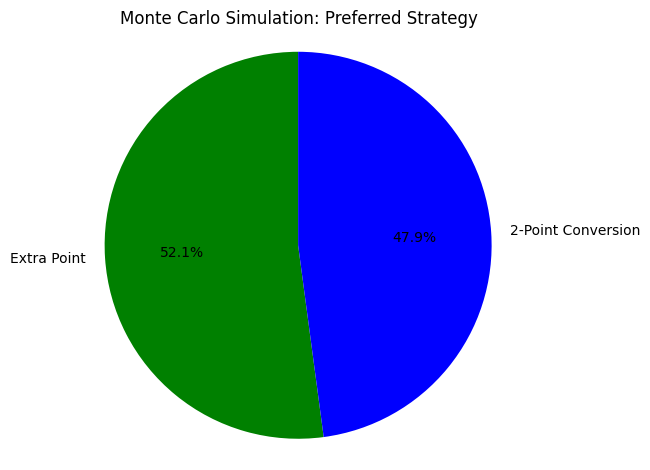

In [7]:
# Plot
labels = ['Extra Point', '2-Point Conversion']
sizes = [chosenXP, chosen2P]
colors = ['green', 'blue']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Monte Carlo Simulation: Preferred Strategy')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.

# Show the plot
plt.tight_layout()
plt.show()


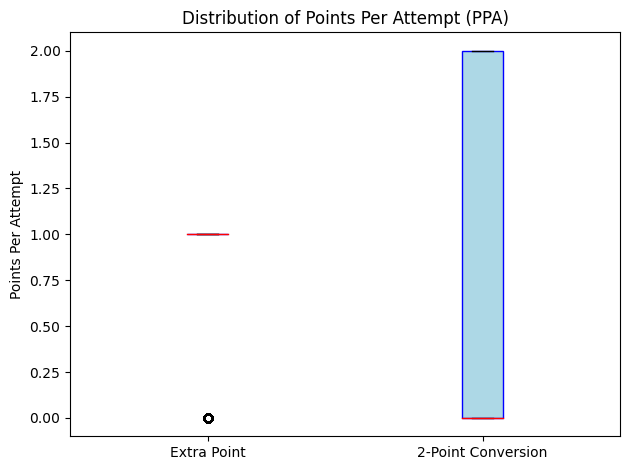

In [8]:
# Data from Monte Carlo simulation
ppa_xp = np.random.binomial(1, overall_XP_success_rate, 10000) * 1  # XP PPA data
ppa_2p = np.random.binomial(1, overall_2P_success_rate, 10000) * 2  # 2P PPA data

# Combine data for boxplot
data = [ppa_xp, ppa_2p]

# Plot
plt.boxplot(data, labels=['Extra Point', '2-Point Conversion'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.ylabel('Points Per Attempt')
plt.title('Distribution of Points Per Attempt (PPA)')

# Show the plot
plt.tight_layout()
plt.show()

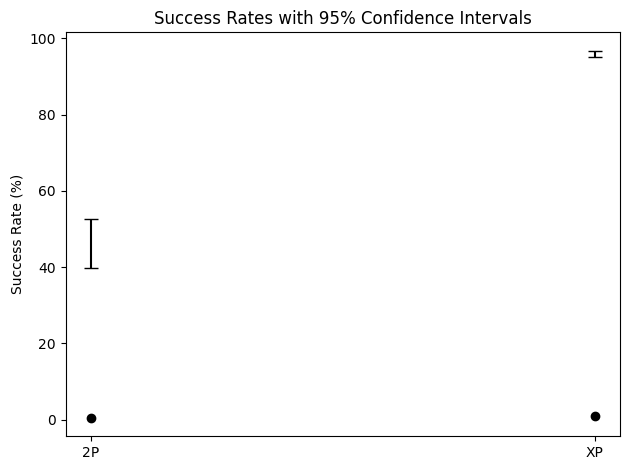

In [9]:
# Data
success_rates = [overall_2P_success_rate, overall_XP_success_rate]
confidence_intervals = [(39.88, 52.74), (95.05, 96.77)]

# Compute error margins
error = [((rate - ci[0]), (ci[1] - rate)) for rate, ci in zip(success_rates, confidence_intervals)]
error_lower, error_upper = zip(*error)

# Plot
plt.errorbar(['2P', 'XP'], success_rates, yerr=[error_lower, error_upper], fmt='o', capsize=5, color='black')
plt.ylabel('Success Rate (%)')
plt.title('Success Rates with 95% Confidence Intervals')

# Show the plot
plt.tight_layout()
plt.show()


#### Conclusion
The Monte Carlo simulation suggests that XP is marginally more favorable than 2P based on the historical success rates. However, the difference is slight, with XP being the better choice in approximately 52.44% of simulations and 2P in 47.56%. This indicates that while XP is slightly more consistent, 2P remains a competitive strategy, especially in high-stakes scenarios where maximizing points is crucial.

### Comparative Analysis

We will compare the success rates of 2-point conversions and XPs using hypothesis testing (e.g., independent t-tests) to assess if the difference in success rates is statistically significant. We will also use confidence intervals to evaluate the precision of the estimated success rates.

Null Hypothesis (H0): When considering the expected point value, the mean success rate of 2-point conversions is equal to the mean success rate of XPs.

Alternative Hypothesis (Ha): The mean success rate of 2-point conversions differs from the mean success rate of XPs.

In [3]:
df['2P_PPA'] = (df['2PM'] * 2) / df['2PA']
df['XP_PPA'] = (df['XPM'] * 1) / df['XPA']

t_stat, p_value = stats.ttest_ind(df['2P_PPA'], df['XP_PPA'])

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Calculate the means and standard deviations of both
mean_2P_PPA = np.mean(df['2P_PPA'])
mean_XP_PPA = np.mean(df['XP_PPA'])

std_2P_PPA = np.std(df['2P_PPA'], ddof=1)
std_XP_PPA = np.std(df['XP_PPA'], ddof=1)

n_2P = len(df['2P_PPA'])
n_XP = len(df['XP_PPA'])

# Calculate the standard error of the difference in means
se_diff = np.sqrt((std_2P_PPA**2 / n_2P) + (std_XP_PPA**2 / n_XP))

# Calculate the t-critical value for 95% confidence (two-tailed)
t_critical = stats.t.ppf(1 - 0.025, df=min(n_2P, n_XP) - 1)

# Calculate the margin of error
margin_of_error = t_critical * se_diff

# Calculate the confidence interval for the difference in means
ci_lower = (mean_2P_PPA - mean_XP_PPA) - margin_of_error
ci_upper = (mean_2P_PPA - mean_XP_PPA) + margin_of_error

# Print the confidence interval for the difference in PPA
print(f"95% Confidence Interval for the difference in PPA: ({ci_lower}, {ci_upper})")

T-statistic: -0.4995799005766014
P-value: 0.6190841193246036
95% Confidence Interval for the difference in PPA: (-0.16673428925822556, 0.101055862507516)


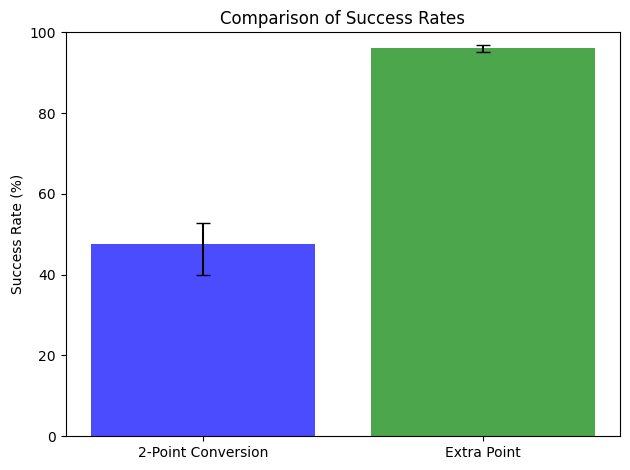

In [4]:
# Visuals for Data
success_rates = [overall_2P_success_rate, overall_XP_success_rate]  # Success rates for 2P and XP
confidence_intervals = [(39.88, 52.74), (95.05, 96.77)]  # 95% CI for 2P and XP

# Extract CI bounds
ci_lower = [rate - ci[0] for rate, ci in zip(success_rates, confidence_intervals)]
ci_upper = [ci[1] - rate for rate, ci in zip(success_rates, confidence_intervals)]

# Plot
labels = ['2-Point Conversion', 'Extra Point']
x_pos = np.arange(len(labels))
plt.bar(x_pos, success_rates, yerr=[ci_lower, ci_upper], capsize=5, color=['blue', 'green'], alpha=0.7)
plt.xticks(x_pos, labels)
plt.ylabel('Success Rate (%)')
plt.title('Comparison of Success Rates')
plt.ylim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()

#### Conclusion
The t-test results indicate that there is no statistically significant difference between the success rates of 2-point conversions and XP after accounting for the difference in points they contribute. The p-value of 0.6191, which is greater than the common significance level of 0.05, suggests that we fail to reject the null hypothesis.

Additionally, the 95% confidence interval for the difference in success rates between 2-point conversions and extra points ranges from -0.1667 to 0.1011, which includes zero. This further supports the conclusion that the difference is not statistically significant. Therefore, after adjusting for the different point values, we do not find strong evidence to suggest that one option is significantly more successful.